# Black-Scholes-Merton Hedging with and without transaction costs

# Summary

* [1.Simulating Geometric brownian Motion](#1)
* [2.Call & Puts pricing using BSM](#2)
* [3.Simulating Hedging scenarios](#3)
    * [3.1 impact of hedging frequency](#3.1)
* [4. transaction costs](#4)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

<a id='1' > </a>
# <u>1.Simulating Geometric Brownian Motion

Lets first write a function that returns a matrix containing the paths of a simulated GBM, given some parameters.

In [2]:
def GBM(n_paths, n_periods, S_0, mu, sigma, T, seed=None):
    """
    Simulate Geometric Brownian Motion (GBM) for asset prices with an optional random seed.

    Parameters:
    n_paths (int): Number of simulated price paths.
    n_periods (int): Number of time steps.
    S_0 (float): Initial asset price.
    mu (float): Expected return (drift).
    sigma (float): Volatility (standard deviation of returns).
    T (float): Total time (e.g., in years).
    seed (int, optional): Random seed for reproducibility.

    Returns:
    numpy.ndarray: Simulated paths of shape (n_periods+1, n_paths).
    """
    if seed is not None:
        np.random.seed(seed)  # Set random seed

    dt = T / n_periods  # Time step
    S = np.zeros((n_periods + 1, n_paths))
    S[0] = S_0  # Initial price

    # Generate random Brownian increments
    dW = np.random.randn(n_periods, n_paths) * np.sqrt(dt)

    # Simulate GBM paths
    for t in range(1, n_periods + 1):
        S[t] = S[t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * dW[t-1])

    return S

We can check whether that works using some arbitrary parameters and plotting the results :

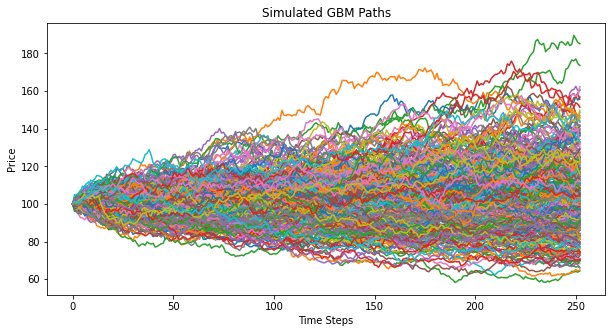

In [3]:
# Parameters
n_paths = 300
n_periods = 252
S_0 = 100
mu = 0.05
sigma = 0.2
T = 1
seed = 42  # Set a fixed seed

# Simulate with seed
paths = GBM(n_paths, n_periods, S_0, mu, sigma, T, seed=seed)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(paths)
plt.title("Simulated GBM Paths")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.show()

<a id='2' > </a>
# <u>2. Calls & Puts pricing using BSM

We simply define the functions that give us the pricing and the delta of a standard european call/put option :

In [4]:
def European_Call_price(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def European_Put_price(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

def European_Call_Delta(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

def European_Put_Delta(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1) - 1

<a id='3' > </a>
# <u>3. Simulating Hedging Scenarios

We will simulate the hedging of the sale of a call option, hedged by the stock itself (delta hedging)

In [34]:
def Delta_Hedge_Call(path, K, mu, T, r, sigma, freq):
    # Compute the time interval between successive points on the path.
    timestep = T / (len(path) - 1)
    
    # Initialize the cash account and stock position.
    cash = 0.0
    # At time 0: sell the call and buy delta shares.
    S0 = path[0]
    delta = European_Call_Delta(S0, K, T, mu, sigma)
    call_price = European_Call_price(S0, K, T, mu, sigma)
    # Cash from selling the call minus the cost of buying delta shares.
    cash = call_price - delta * S0

    # Track the last time index at which we rebalanced.
    last_rebal_index = 0

    # Loop over the time indices, rebalancing only when i % freq == 0,
    # and stopping before the terminal time.
    for i in range(1, len(path) - 1):
        if i % freq == 0:
            # Calculate elapsed time since the last rebalancing.
            dt = (i - last_rebal_index) * timestep
            # Grow the cash account at the risk-free rate.
            cash *= np.exp(r * dt)
            
            # Update the stock price and time-to-maturity.
            S = path[i]
            tau = T - i * timestep
            
            # Compute the new delta.
            new_delta = European_Call_Delta(S, K, tau, mu, sigma)
            
            # Adjust the stock position: buy (or sell) the additional shares.
            cash -= (new_delta - delta) * S
            delta = new_delta  # update our hedge
            last_rebal_index = i

    # Finally, update the cash account from the last rebalancing to maturity.
    dt_final = (len(path) - 1 - last_rebal_index) * timestep
    cash *= np.exp(r * dt_final)
    
    # Use the actual terminal stock price.
    S_terminal = path[-1]
    # The portfolio value is the value of the stock position plus the cash account.
    terminal_portfolio_value = delta * S_terminal + cash
    # The call payoff is max(S_T - K, 0)
    call_payoff = max(S_terminal - K, 0)
    
    results = {
        'Cash': cash,
        'Terminal_Delta': delta,
        'Terminal_Stock_Price': S_terminal,
        'Terminal_portfolio_value': terminal_portfolio_value,
        'Call_Payoff': call_payoff
    }
    return results


In [39]:
path = paths[:,110] #First Path
K = 100
r = 0.05
freq = 1 

Delta_Hedge_Call(path,K,mu,T,r,sigma,freq)

{'Cash': -99.98381853536537,
 'Terminal_Delta': 1.0,
 'Terminal_Stock_Price': 129.7441727005046,
 'Terminal_portfolio_value': 29.760354165139233,
 'Call_Payoff': 29.744172700504606}

Among other things, we can plot the hedge and see visually the hedging error around the high gamma zones : 

In [69]:
def plot_hedge(paths,K,mu,T,r,sigma,freq):
    Call_Payoffs = []
    Portfolio_value = []
    Terminal_Prices = []

    for i in range(n_paths):
        path = paths[:,i]
        # Simulate the hedge on this path.
        Hedge_Sim = Delta_Hedge_Call(path,K,mu,T,r,sigma,freq)

        # Append simulation outputs to lists.
        Call_Payoffs.append(Hedge_Sim['Call_Payoff'])
        Portfolio_value.append(Hedge_Sim['Terminal_portfolio_value'])
        Terminal_Prices.append(Hedge_Sim['Terminal_Stock_Price'])

    # Plot the results:
    plt.figure(figsize=(12, 9))
    plt.scatter(Terminal_Prices, Call_Payoffs, color='blue', alpha=0.6, label='Call Payoff')
    plt.scatter(Terminal_Prices, Portfolio_value, color='red', alpha=0.6, label='Portfolio Value')
    plt.xlabel("Terminal Stock Price")
    plt.ylabel("Value")
    plt.title("Delta Hedging Simulation: Call Payoff vs. Portfolio Value")
    plt.legend()
    plt.grid(True)
    plt.show()
     
    return

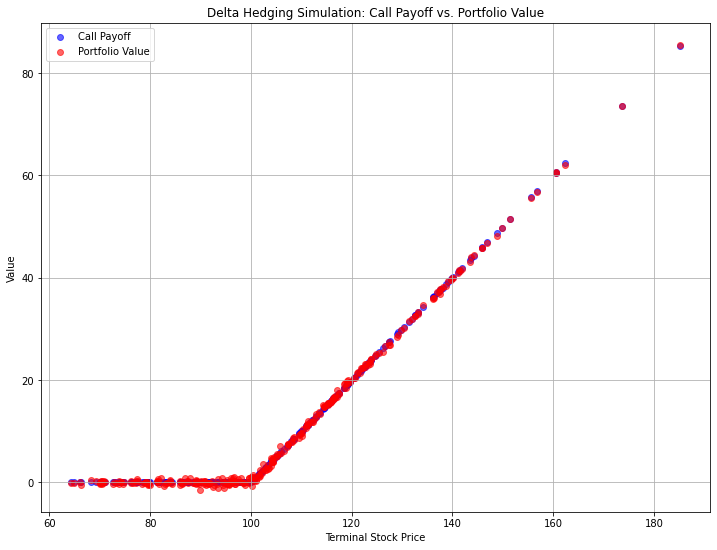

In [43]:
plot_hedge(paths,K,mu,T,r,sigma,freq)

<a id='3.1' > </a>
## <u>3.1 Impact of hedging frequency

We can modify the frequency of hedging to see the difference in hedging error : 

frequency = 1



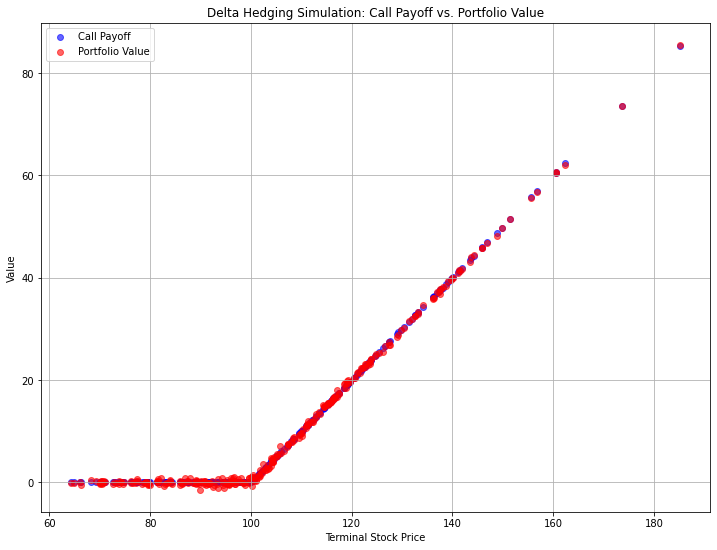

frequency = 5



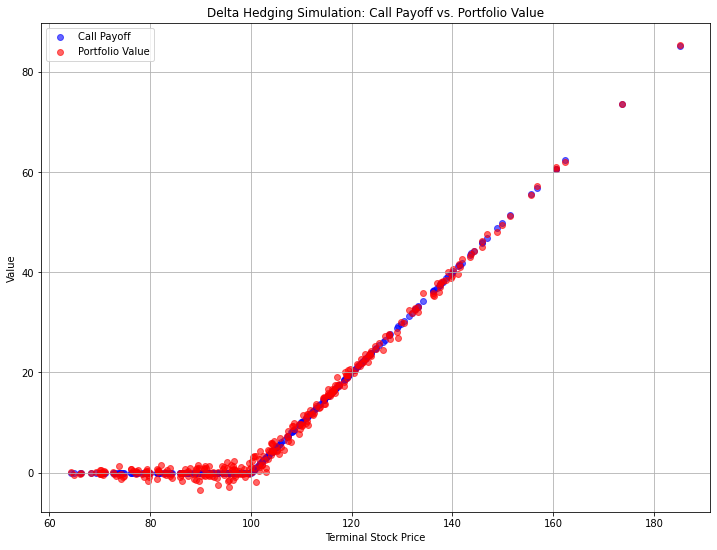

frequency = 10



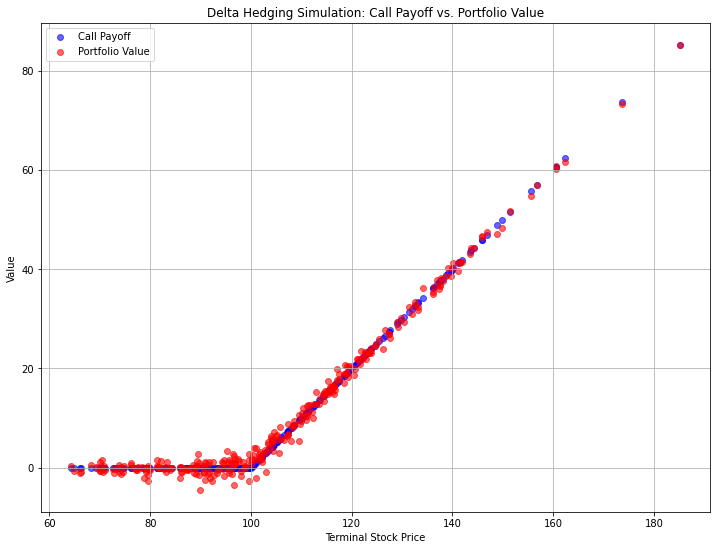

frequency = 30



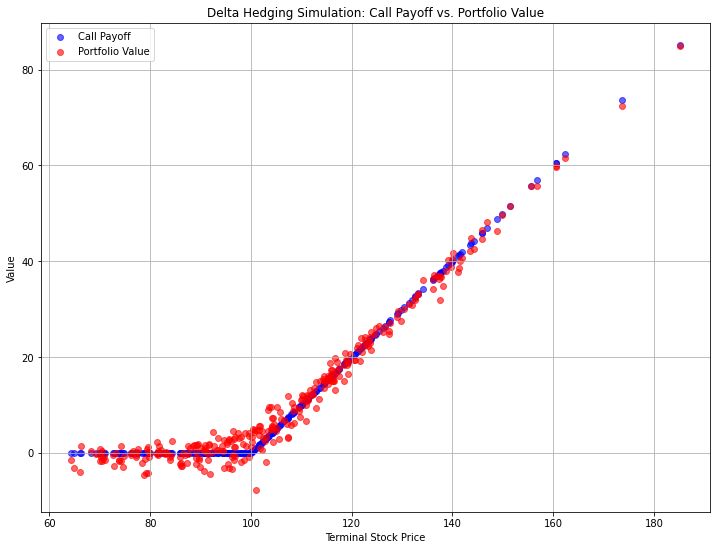

In [44]:
print('frequency = 1\n')
plot_hedge(paths,K,mu,T,r,sigma,1)
print('frequency = 5\n')
plot_hedge(paths,K,mu,T,r,sigma,5)
print('frequency = 10\n')
plot_hedge(paths,K,mu,T,r,sigma,10)
print('frequency = 30\n')
plot_hedge(paths,K,mu,T,r,sigma,30)

<a id='4' > </a>
# <u>4. Adding Transaction costs

In order to adjust for transaction costs We will use 2 methods. 
* The first one is simply adding a round-trip cost of $\Phi$ . We assume it is fixed, each sale of a stock will be $\Phi$ % too low and each purchase $\Phi$ % too high. 
* The second one will be analyzing Leland's Method, who showed in 1985 in the Journal of Finance, that such a round trip cost would be equivalent to adjusting the volatility so that : 

$$
\sigma_{\text{adjusted}} = \sigma \left( 1 + \sqrt{\frac{2}{\pi}}\,\frac{\phi}{\sigma}\sqrt{N} \right)^{\frac{1}{2}}
$$

<a id='4.1' > </a>
## <u>4.1 round trip transaction costs

In [60]:
def Delta_Hedge_Call_TC(path, K, mu, T, r, sigma, freq, psi):
    # Compute the time interval between successive points on the path.
    timestep = T / (len(path) - 1)
    
    # Initialize the cash account and stock position.
    cash = 0.0
    # At time 0: sell the call and buy delta shares.
    S0 = path[0]
    delta = European_Call_Delta(S0, K, T, mu, sigma)
    call_price = European_Call_price(S0, K, T, mu, sigma)
    # Cash from selling the call minus the cost of buying delta shares.
    cash = call_price - delta * S0*(1+psi)

    # Track the last time index at which we rebalanced.
    last_rebal_index = 0

    # Loop over the time indices, rebalancing only when i % freq == 0,
    # and stopping before the terminal time.
    for i in range(1, len(path) - 1):
        if i % freq == 0:
            # Calculate elapsed time since the last rebalancing.
            dt = (i - last_rebal_index) * timestep
            # Grow the cash account at the risk-free rate.
            cash *= np.exp(r * dt)
            
            # Update the stock price and time-to-maturity.
            S = path[i]
            tau = T - i * timestep
            
            # Compute the new delta and determine whether it will be a sale or a purchase of stock
            new_delta = European_Call_Delta(S, K, tau, mu, sigma)
            if new_delta > delta :
                indic = 1
            if new_delta < delta :
                indic = -1
            
            # Adjust the stock position: buy (or sell) the additional shares.
            cash -= (new_delta - delta) * S*(1+ (indic * psi))
            delta = new_delta  # update our hedge
            last_rebal_index = i

    # Finally, update the cash account from the last rebalancing to maturity.
    dt_final = (len(path) - 1 - last_rebal_index) * timestep
    cash *= np.exp(r * dt_final)
    
    # Use the actual terminal stock price.
    S_terminal = path[-1]
    # The portfolio value is the value of the stock position plus the cash account.
    terminal_portfolio_value = delta * S_terminal + cash
    # The call payoff is max(S_T - K, 0)
    call_payoff = max(S_terminal - K, 0)
    
    results = {
        'Cash': cash,
        'Terminal_Delta': delta,
        'Terminal_Stock_Price': S_terminal,
        'Terminal_portfolio_value': terminal_portfolio_value,
        'Call_Payoff': call_payoff
    }
    return results

In [58]:
def plot_hedge_TC(paths,K,mu,T,r,sigma,freq,psi):
    Call_Payoffs = []
    Portfolio_value = []
    Terminal_Prices = []

    for i in range(n_paths):
        path = paths[:,i]
        # Simulate the hedge on this path.
        Hedge_Sim = Delta_Hedge_Call_TC(path,K,mu,T,r,sigma,freq,psi)

        # Append simulation outputs to lists.
        Call_Payoffs.append(Hedge_Sim['Call_Payoff'])
        Portfolio_value.append(Hedge_Sim['Terminal_portfolio_value'])
        Terminal_Prices.append(Hedge_Sim['Terminal_Stock_Price'])

    # Plot the results:
    plt.figure(figsize=(12, 9))
    plt.scatter(Terminal_Prices, Call_Payoffs, color='blue', alpha=0.6, label='Call Payoff')
    plt.scatter(Terminal_Prices, Portfolio_value, color='red', alpha=0.6, label='Portfolio Value')
    plt.xlabel("Terminal Stock Price")
    plt.ylabel("Value")
    plt.title("Delta Hedging Simulation: Call Payoff vs. Portfolio Value")
    plt.legend()
    plt.grid(True)
    plt.show()
     
    return

phi = 0%


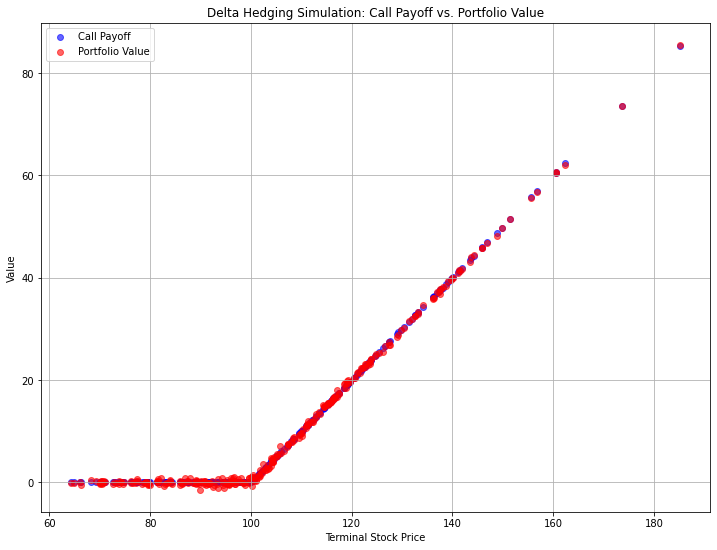

phi = 0,01%


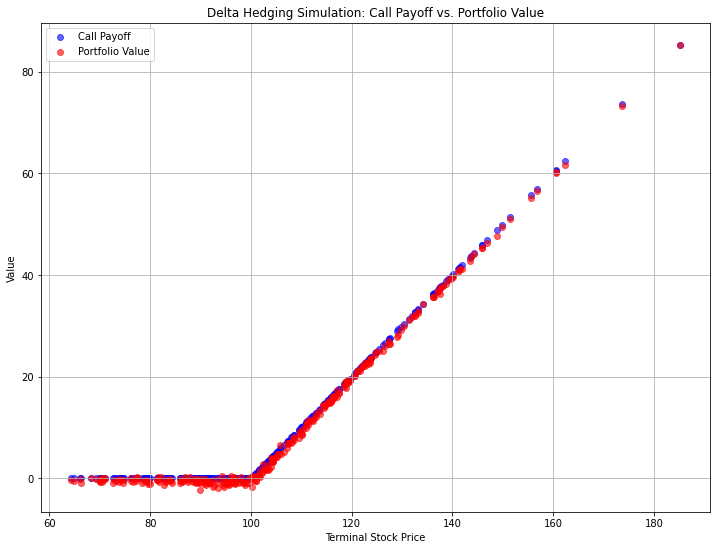

phi = 0.05%


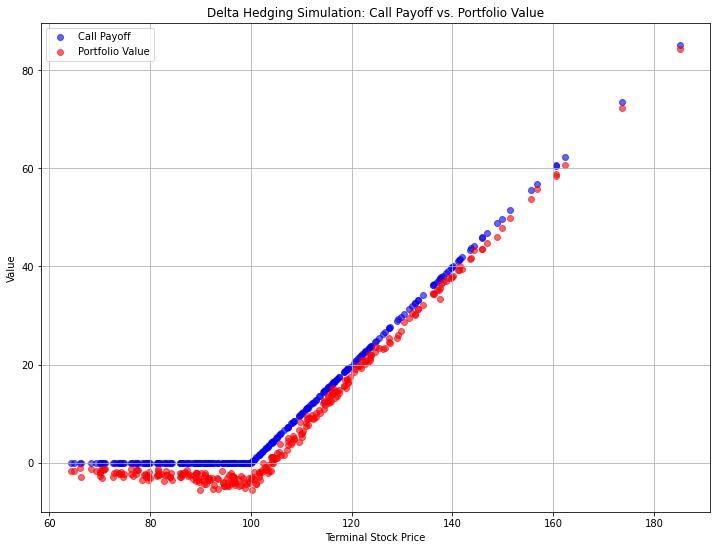

phi = 0.1%


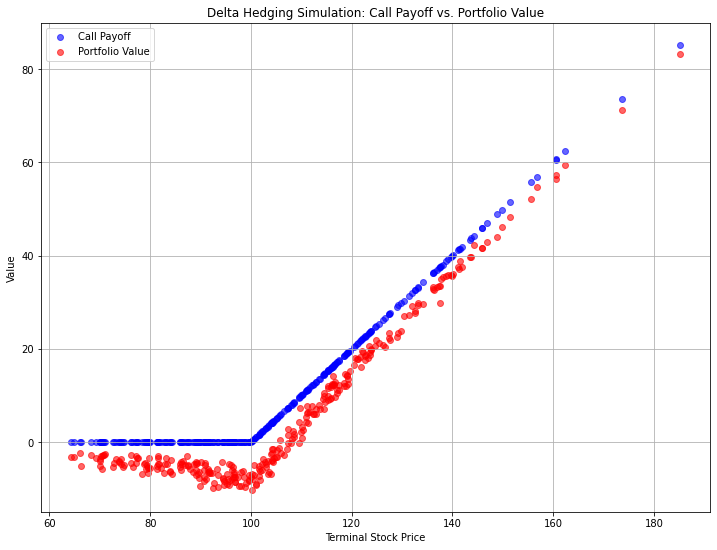

In [63]:
print('phi = 0%')
plot_hedge_TC(paths,K,mu,T,r,sigma,freq,0.000)
print('phi = 0,01%')
plot_hedge_TC(paths,K,mu,T,r,sigma,freq,0.001)
print('phi = 0.05%')
plot_hedge_TC(paths,K,mu,T,r,sigma,freq,0.005)
print('phi = 0.1%')
plot_hedge_TC(paths,K,mu,T,r,sigma,freq,0.01)

We can see how a round trip cost particularily affects the options that are close to the money because their hedge needs to be more radically rebalanced.